In [1]:
import ROOT
from ROOT import TMVA

import numpy as np
import time

Welcome to JupyROOT 6.15/01


In [2]:
inputFile = ROOT.TFile("Higgs_data.root")
inputFile.ls()

TFile**		Higgs_data.root	
 TFile*		Higgs_data.root	
  KEY: TTree	sig_tree;1	Signal Tree
  KEY: TTree	bkg_tree;1	Background Tree


In [3]:
sig_evts = inputFile.sig_tree.AsMatrix(['m_jj','m_jjj','m_lv','m_jlv','m_bb','m_wbb','m_wwbb'])

In [4]:
print(sig_evts)

[[0.86705905 1.12717986 1.21166396 ... 0.6940676  0.7558133  0.76165789]
 [1.93866849 1.23389792 0.99006349 ... 0.90061414 0.91761291 1.08336937]
 [0.88164133 0.84538066 0.99740821 ... 0.78713214 0.65766817 0.72114676]
 ...
 [0.33098638 1.1221211  0.98452914 ... 0.99097657 0.81343573 0.75893229]
 [0.88228101 0.75431746 0.99221778 ... 0.57071501 0.59710413 0.5682196 ]
 [1.13515067 0.99333692 0.97866201 ... 0.13703139 0.75950158 0.79101425]]


In [5]:
bkg_evts = inputFile.bkg_tree.AsMatrix(['m_jj','m_jjj','m_lv','m_jlv','m_bb','m_wbb','m_wwbb'])

In [6]:
print(bkg_evts)

[[0.57275063 1.07768857 0.98565662 ... 0.88531804 0.84836376 0.84490532]
 [1.71470094 1.39858317 0.98444569 ... 0.99755013 1.05524576 0.96557057]
 [1.1574676  0.86232114 0.98406738 ... 0.9502396  0.8275283  0.86550403]
 ...
 [0.97802567 1.02362823 1.27613914 ... 1.50466847 1.01351249 0.91299349]
 [0.82587695 0.89610744 1.01591611 ... 0.8591187  0.80801648 0.73538506]
 [0.56384832 0.501809   0.98341399 ... 0.50350058 0.65547013 0.57149076]]


### Make Input data and target arrays
Make array of target values. Traget = 1 for signal events and = 0 for background ones

In [7]:
sig_target = np.arange(len(sig_evts), dtype='float')
sig_target[0:len(sig_target)]=1.
bkg_target = np.arange(len(bkg_evts), dtype='float')
bkg_target[0:len(bkg_target)]=0.
print(sig_target)

[1. 1. 1. ... 1. 1. 1.]


In [8]:
## Use numpy function concatenate to append signal and backgorund arrays
inputs = np.concatenate((sig_evts,bkg_evts))
targets = np.concatenate((sig_target,bkg_target))

#### Inspect  input distributions

We look for example at some input distributions

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


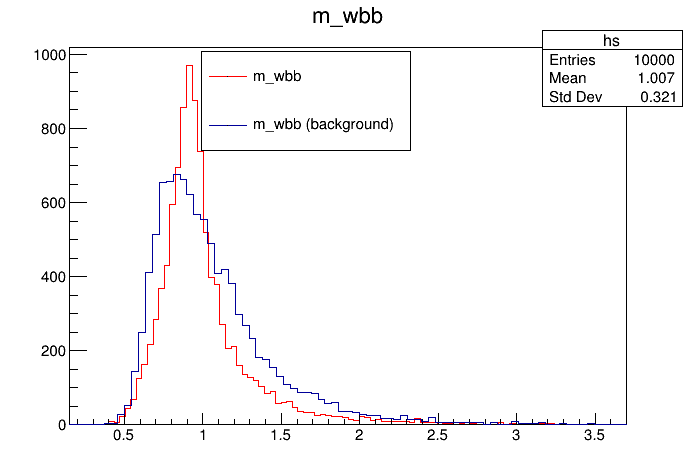

In [9]:
## we make an histogram of variable m_wbb (ivar=5)
ivar = 5
varName = "m_wbb"
h1 = ROOT.TH1D("hs",varName,100,1,0)
h2 = ROOT.TH1D("hb",varName + " (background)",100,1,0)
dims = inputs.shape
nevt = dims[0]
for i in range(0,nevt):
    if (targets[i] == 1.):
        h1.Fill(inputs[i,ivar])
    else:
        h2.Fill(inputs[i,ivar])
        
        
h1.SetLineColor(ROOT.kRed)
h1.Draw()
h2.Draw("SAME")
ROOT.gPad.BuildLegend()
ROOT.gPad.Draw()

### Run Keras 

In [10]:
import numpy as np
np.random.seed(1234)
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import subprocess
import h5py
import pickle

from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam, SGD

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


####  Use scikit-learn function to split data in test and training set

In [11]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(
        inputs, targets, test_size=0.10, random_state=123)

In [12]:
print(targets_train)

[1. 1. 0. ... 0. 0. 0.]


#### Define the Keras model

In [13]:
# Define model
model = Sequential()
model.add(Dense(64, kernel_initializer='glorot_normal', activation='tanh', input_dim=7))
#model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='tanh'))
model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))


# Store model to file
##model.save('model_dense.h5')

# Print summary of model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 8,897
Trainable params: 8,897
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Set loss and optimizer
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

#### Train the Keras model

#### Apply input variable transformations using scikit-learn

We could transform input variable using some transformation from scikit-learn. 
For example we could use StandardScaler transformation from scikit.
This transforms variable to be of mean zero and standard deviation=1

Example code: (not used so far)

```
from sklearn.preprocessing import StandardScaler
preprocessing_input = StandardScaler()
preprocessing_input.fit(inputs_train)
trans_inputs_train =  preprocessing_input.transform(inputs_train)
```

In [15]:
model.fit(inputs_train,targets_train,batch_size=100,epochs=20,validation_split=0.30)
#model.fit(trans_inputs_train,targets,batch_size=100,epochs=10,validation_split=0.30)

Train on 12600 samples, validate on 5400 samples
Epoch 1/20
12600/12600 [==============================] - 1s 91us/step - loss: 0.6826 - acc: 0.5498 - val_loss: 0.6709 - val_acc: 0.5504
Epoch 2/20
12600/12600 [==============================] - 1s 56us/step - loss: 0.6640 - acc: 0.5985 - val_loss: 0.6536 - val_acc: 0.6167
Epoch 3/20
12600/12600 [==============================] - 1s 48us/step - loss: 0.6479 - acc: 0.6244 - val_loss: 0.6446 - val_acc: 0.6346
Epoch 4/20
12600/12600 [==============================] - 1s 51us/step - loss: 0.6378 - acc: 0.6390 - val_loss: 0.6317 - val_acc: 0.6507
Epoch 5/20
12600/12600 [==============================] - 1s 49us/step - loss: 0.6325 - acc: 0.6460 - val_loss: 0.6302 - val_acc: 0.6581
Epoch 6/20
12600/12600 [==============================] - 1s 53us/step - loss: 0.6283 - acc: 0.6495 - val_loss: 0.6270 - val_acc: 0.6596
Epoch 7/20
12600/12600 [==============================] - 1s 50us/step - loss: 0.6219 - acc: 0.6537 - val_loss: 0.6264 - val_acc:

2018-10-20 19:26:26.333138: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA


#### Perform prediction with trained model using test set

In [16]:
keras_out = model.predict(inputs_test)
print(keras_out)

[[0.49534348]
 [0.33869833]
 [0.35399076]
 ...
 [0.4223536 ]
 [0.48557988]
 [0.30366942]]


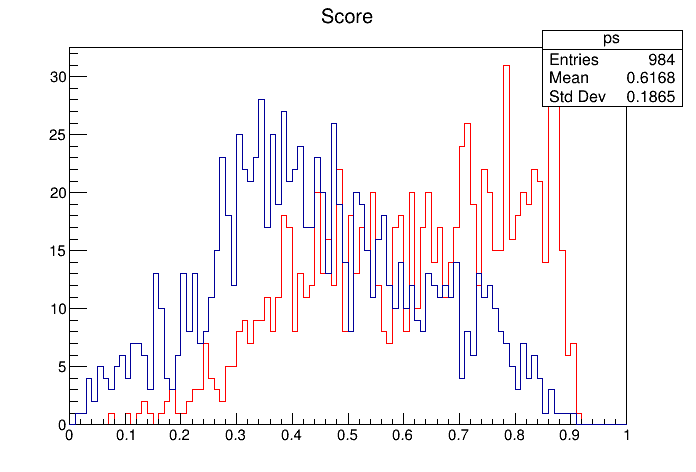

In [17]:
pS = ROOT.TH1D("ps","Score",100,0,1)
pB = ROOT.TH1D("pb","Score (Background)",100,0,1)
for i in range (0,keras_out.shape[0]):
    if (targets_test[i] == 1): 
        pS.Fill(keras_out[i,0])
    else:
        pB.Fill(keras_out[i,0])
        
pS.SetLineColor(ROOT.kRed)
pS.Draw()
pB.Draw('same')
ROOT.gPad.Draw()

#### Compute ROC 

In [18]:
from sklearn import metrics

In [19]:

##y_true = np.hstack((np.ones(quarks.GetEntries()), np.zeros(gluons.GetEntries())))
##y_score = np.hstack((mvaValues_quarks, mvaValues_gluons))
fpr, tpr, thresholds = metrics.roc_curve(targets_test, keras_out)

# Get AUC from ROC
auc = metrics.auc(fpr, tpr)
print('AUC: {}'.format(auc))

AUC: 0.738159968952


#### Save trained model in a file

In [20]:
#model.save('trained_model_dense.h5')

In [21]:
print(inputs_train)

[[0.88702357 0.95453084 0.98725212 ... 0.62646365 0.87867844 0.79225779]
 [1.00401211 1.03367901 1.35047066 ... 1.10024583 0.79959005 0.78664428]
 [0.77781528 0.95035696 0.98657042 ... 1.20908844 1.01778662 0.974774  ]
 ...
 [1.51254749 1.07197857 0.98833537 ... 1.76031756 1.09533727 0.88612032]
 [0.81928593 0.85067874 0.98984611 ... 2.22635937 1.13372147 0.96031088]
 [1.11431277 1.16048193 0.998209   ... 0.58975536 1.08279443 0.98208863]]


### Use Decision Trees from scikit-learn

We create a GradientBoostingClassifier. 
Look at the scikit documentation for all the possible options

In [22]:
from sklearn import tree
from sklearn import ensemble

In [23]:
gtb = ensemble.GradientBoostingClassifier()

In [24]:
start = time.time()
gtb = gtb.fit(inputs_train, targets_train)
end = time.time()
print('elapsed training time = ',end-start)

('elapsed training time = ', 2.0637710094451904)


In [25]:
gtb_out = gtb.predict_proba(inputs_test)

In [26]:
print(gtb_out)
out = gtb_out[:,1]
print(out)

[[0.7843201  0.2156799 ]
 [0.43251267 0.56748733]
 [0.64346602 0.35653398]
 ...
 [0.69294503 0.30705497]
 [0.48864164 0.51135836]
 [0.69174172 0.30825828]]
[0.2156799  0.56748733 0.35653398 ... 0.30705497 0.51135836 0.30825828]


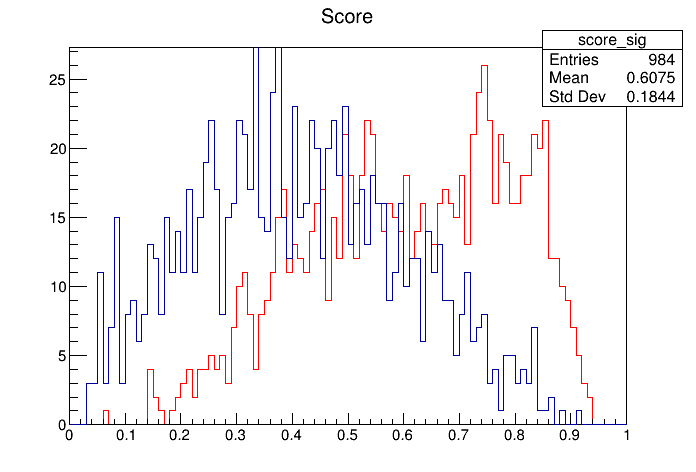

In [27]:
pS = ROOT.TH1D("score_sig","Score",100,0,1)
pB = ROOT.TH1D("score_bkg","Score (Background)",100,0,1)
for i in range (0,out.shape[0]):
    if (targets_test[i] == 1): 
        pS.Fill(out[i])
    else:
        pB.Fill(out[i])
        
pS.SetLineColor(ROOT.kRed)
pS.Draw()
pB.Draw('same')
ROOT.gPad.Draw()

In [28]:
out = gtb_out[:,1]
nevt = out.shape[0]
print(nevt)
ns=0
nb=0
vscores = ROOT.std.vector('float')(nevt)
vtargets = ROOT.std.vector('bool')(nevt)
for ievt in range(0,nevt): 
    #need to use second column
    vscores[ievt] = out[ievt]
    vtargets[ievt] = int(targets_test[ievt])
 
        
##print vtargets
roc = ROOT.TMVA.ROCCurve(vscores,vtargets) 
print (' ROC Integral (AUC) = ',roc.GetROCIntegral())
graph = roc.GetROCCurve()


2000
(' ROC Integral (AUC) = ', 0.7644361956660902)


In [29]:
#c3 = ROOT.TCanvas()
graph.SetLineColor(ROOT.kRed)
graph.Draw('L')
##c3.SaveAs('graph.pdf')

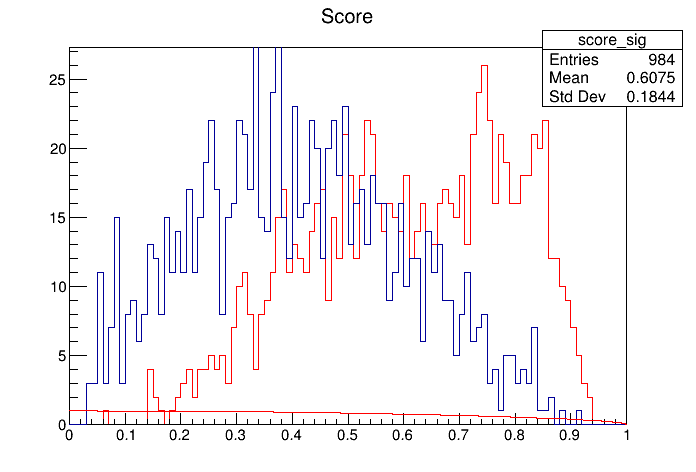

In [31]:
ROOT.gPad.Draw()

In [32]:
fpr, tpr, thresholds = metrics.roc_curve(targets_test, out)

# Get AUC from ROC
auc = metrics.auc(fpr, tpr)
print('AUC: {}'.format(auc))

AUC: 0.764243146245


### Using XGBOOST

In [33]:
import xgboost

In [34]:
xgb_model = xgboost.XGBClassifier()

In [35]:
start=time.time()
xgb_model.fit(inputs_train, targets_train)
end = time.time()
print('elapsed training time = ',end-start)

('elapsed training time = ', 1.0950939655303955)


In [36]:
xgb_out = xgb_model.predict_proba(inputs_test)

In [38]:
print(xgb_out)

[[0.6721802  0.32781985]
 [0.45654404 0.54345596]
 [0.66014075 0.33985925]
 ...
 [0.66714436 0.33285564]
 [0.53046024 0.4695398 ]
 [0.6931692  0.30683082]]


In [39]:
xgb_out.size
out = xgb_out[:,1]
out.size

2000

In [40]:
fpr, tpr, thresholds = metrics.roc_curve(targets_test, out)

In [41]:
auc = metrics.auc(fpr, tpr)
print('AUC: {}'.format(auc))

AUC: 0.766501224313


Warning in <TFile::Append>: Replacing existing TH1: score_sig (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: score_bkg (Potential memory leak).


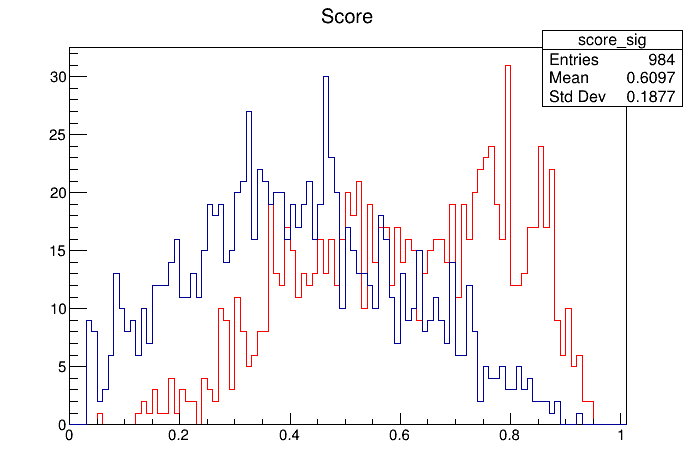

In [42]:
pS = ROOT.TH1D("score_sig","Score",101,0,1.01)
pB = ROOT.TH1D("score_bkg","Score (Background)",101,0,1.01)
for i in range (0,out.shape[0]):
    if (targets_test[i] == 1): 
        pS.Fill(out[i])
    else:
        pB.Fill(out[i])
        
pS.SetLineColor(ROOT.kRed)
pS.Draw()
pB.Draw('same')
ROOT.gPad.Draw()